In [1]:
import pandas as pd
import geopandas as gpd
import os
from scipy.spatial import cKDTree
from shapely.geometry import Point
import osmnx as osm
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
target = 'PROSTITUTION'

In [3]:
in_folder = r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\feature_engineering"

In [4]:
#reading csvs
df = pd.read_csv(os.path.join(in_folder,'df_EDA.csv'))
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=gpd.points_from_xy(df.X,df.Y))
gdf.to_crs('EPSG:7131',inplace= True)

In [5]:
df = pd.read_csv(os.path.join(in_folder,'df_target.csv'))
gdf_eda = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=gpd.points_from_xy(df.X,df.Y))
gdf_eda.to_crs('EPSG:7131',inplace= True)

Creating features from the cluster polygons.

<AxesSubplot:>

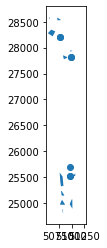

In [6]:
#converting the labels into a array and filtering the clusters.
labels_filtro = gdf_eda.loc[gdf_eda["labels"] > 0 ]["labels"].to_numpy()
#creating polygons.
hulls = gdf_eda.loc[gdf_eda["labels"] > 0][['geometry']].dissolve(by=labels_filtro).convex_hull
hulls.plot()

In [7]:
#converting into a gdf to manage the data
gdf_hulls = gpd.GeoDataFrame(hulls,columns=['geometry'])

<AxesSubplot:>

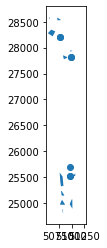

In [8]:
#Now we need to convert the crs to a projected coordinated system. This allows us to create buffers.
gdf_hulls.plot()

<AxesSubplot:>

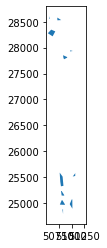

In [9]:
#replacing the points mixed to the polygons with buffers.
aux = []
for element in gdf_hulls['geometry']:
    if str(element).startswith('POLYGON'):
        aux.append(element)
    else:
        aux.append(element.buffer(0.0005))
        
gdf_hulls['geometry'] = aux
gdf_hulls.plot()

In [10]:
#overlay the crimes that ocurred inside the polygons area.
def overlay(df):
    
    intersecao_cluster  = gpd.overlay(df, gdf_hulls, how = "intersection")
    intersecao_cluster["cluster"] = "1"
    diferenca_cluster = gpd.overlay(df, gdf_hulls, how = "symmetric_difference").reset_index()
    diferenca_cluster["cluster"] = "0"
    df = intersecao_cluster.append(diferenca_cluster)
    
    return df

Creating features from Open Street Map tags.

In [11]:
#Reading the same shapefile from the data cleaning step.
sf = gpd.read_file(r'C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\eda_esda\sf_shape.shp')

<AxesSubplot:>

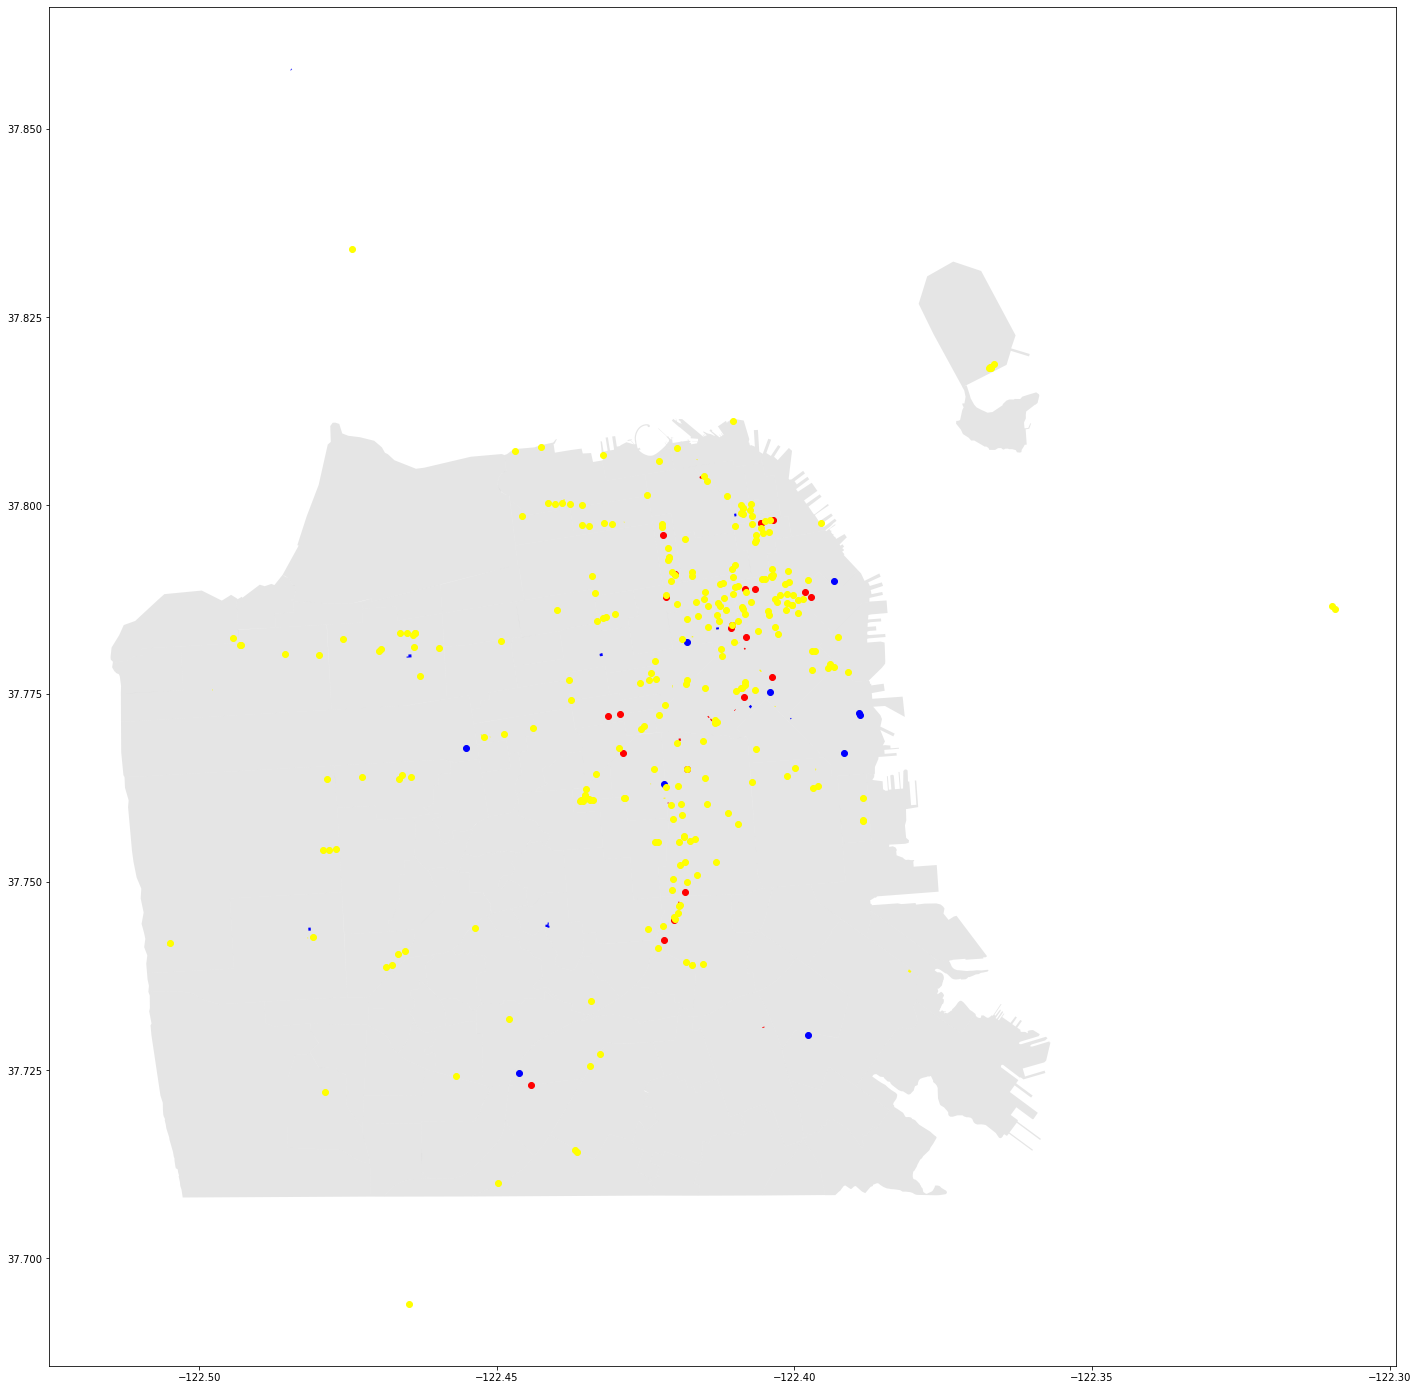

In [12]:
#Retrieving the police stations in San Franscico area.
adress = "São Francisco , CA, US"
police = osm.geometries.geometries_from_address(adress,{"amenity":"police"}, dist=10000).reset_index()
nightclub = osm.geometries.geometries_from_address(adress,{"amenity":"nightclub"}, dist=10000).reset_index()
bar = osm.geometries.geometries_from_address(adress,{"amenity":"bar"}, dist=10000).reset_index()

#plotting the results of our query.
fig, ax = plt.subplots (figsize = (25,25))
sf.plot(ax = ax, alpha = 0.2, color = "grey")
police.plot(ax = ax,color = "blue")
nightclub.plot(ax = ax,color = "red")
bar.plot(ax = ax,color = "yellow")

In [13]:
#Creating centroids to calculate the distance
police['geometry'] = police['geometry'].centroid
police['lon'] = police.geometry.apply(lambda p: p.x)
police['lat'] = police.geometry.apply(lambda p: p.y)

nightclub['geometry'] = nightclub['geometry'].centroid
nightclub['lon'] = nightclub.geometry.apply(lambda p: p.x)
nightclub['lat'] = nightclub.geometry.apply(lambda p: p.y)

bar['geometry'] = bar['geometry'].centroid
bar['lon'] = bar.geometry.apply(lambda p: p.x)
bar['lat'] = bar.geometry.apply(lambda p: p.y)

C:\Users\eduar\AppData\Local\Temp/ipykernel_28176/3570777660.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  police['geometry'] = police['geometry'].centroid
C:\Users\eduar\AppData\Local\Temp/ipykernel_28176/3570777660.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nightclub['geometry'] = nightclub['geometry'].centroid
C:\Users\eduar\AppData\Local\Temp/ipykernel_28176/3570777660.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bar['geometry'] = bar['geometry'].centroid


Creating a function to calculate the distance between the crimes and the Police Stations. That can be re-use with another tags.

In [14]:
def ckdnearest(gdA, dicionario):
    lista_series = []
    for chave, gdB in dicionario.items():
        gdB.to_crs('EPSG:7131',inplace= True)
        name = 'dist_{}'.format(chave)
        nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
        nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
        btree = cKDTree(nB)
        dist, idx = btree.query(nA, k=1)
        gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
        gdA = pd.concat([gdA.reset_index(drop=True),pd.Series(dist, name=name)], axis=1)

    return gdA

In [15]:
dicion_gdbs = {"police":police,'nightclub':nightclub,'bar':bar}

In [16]:
def spatial_feat_eng(gdf):
    
    df_overlay = overlay(gdf)
    df_distance = ckdnearest(df_overlay, dicion_gdbs)
    
    return df_distance 

In [17]:
gdf = spatial_feat_eng(gdf)

C:\Users\eduar\AppData\Local\Temp/ipykernel_28176/1163198774.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  diferenca_cluster = gpd.overlay(df, gdf_hulls, how = "symmetric_difference").reset_index()


<AxesSubplot:xlabel='cluster', ylabel='count'>

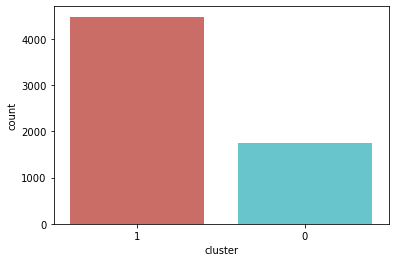

In [19]:
import seaborn as sns
sns.countplot(x='cluster',data=gdf.loc[gdf[target] == 1],palette="hls")

<AxesSubplot:xlabel='cluster', ylabel='count'>

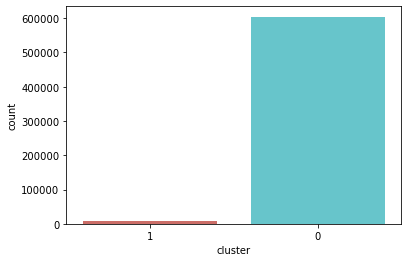

In [20]:
sns.countplot(x='cluster',data=gdf.loc[gdf[target] == 0],palette="hls")

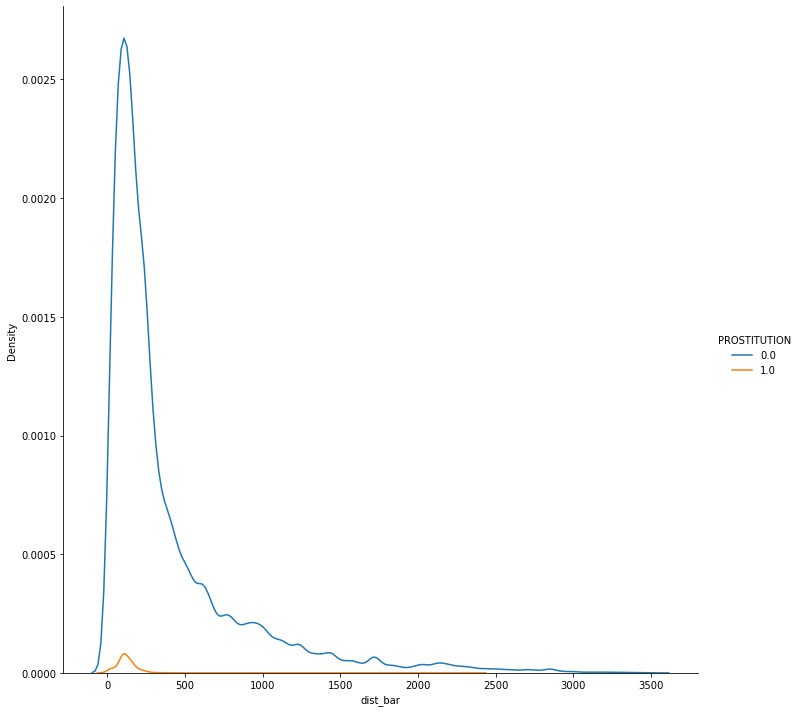

In [21]:
sns.displot(x = 'dist_bar', hue="PROSTITUTION", data = gdf, kind="kde", height=10, aspect=1.0)

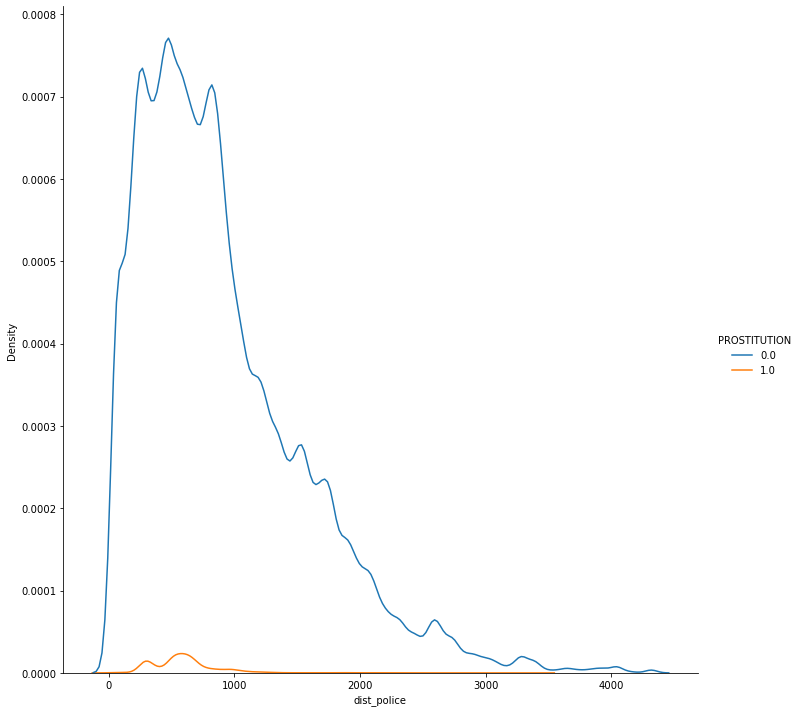

In [22]:
sns.displot(x = 'dist_police', hue="PROSTITUTION", data = gdf, kind="kde", height=10, aspect=1.0)

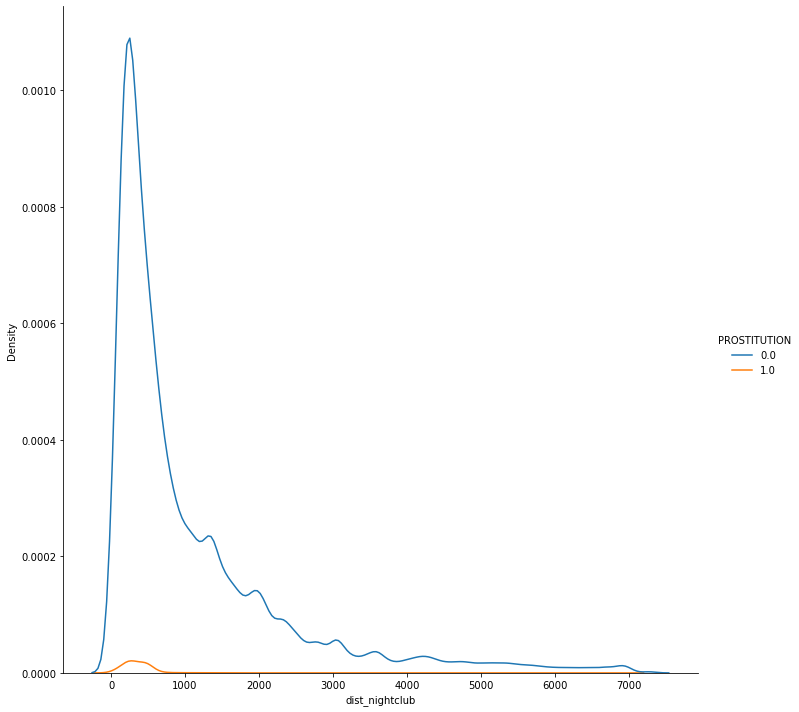

In [23]:
sns.displot(x = 'dist_nightclub', hue="PROSTITUTION", data = gdf, kind="kde", height=10, aspect=1.0)

In [24]:
gdf[["dist_bar","dist_police","dist_nightclub",target]].corr(method='spearman')

,dist_bar,dist_police,dist_nightclub,PROSTITUTION
dist_bar,1.000000,0.447398,0.571782,-0.075181
dist_police,0.447398,1.000000,0.591427,-0.040452
dist_nightclub,0.571782,0.591427,1.000000,-0.064740
PROSTITUTION,-0.075181,-0.040452,-0.064740,1.000000


Creating a simple function to retrieve addresses peculiarities.

In [25]:
def feat_eng(df_T):
    
    #Time
    df_T['hour'] = pd.to_datetime(df_T['Dates']).dt.hour
    df_T['Month'] = pd.to_datetime(df_T['Dates']).dt.month
    df_T['Year'] = pd.to_datetime(df_T['Dates']).dt.year
    
    #Addresses 
    df_T['ST'] = df_T['Address'].str.contains(" ST", case=True)
    df_T['AV'] = df_T['Address'].str.contains(" AV", case=True)
    df_T['Block'] = df_T['Address'].str.contains(" Block", case=True)
    df_T['crossing'] = df_T['Address'].str.contains(" / ", case=True)
    
    #Parts of a day
    df_T["late_night"] = (df_T["hour"] <= 6).astype(int)
    df_T["evening"] = (df_T["hour"] >= 18).astype(int)
    df_T["night_time"] = df_T["late_night"] + df_T["evening"]
    
    return df_T

In [26]:
feat_eng(gdf)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PROSTITUTION,...,geometry,cluster,index,dist_police,dist_nightclub,dist_bar,ST,AV,Block,crossing
0,2013-04-20 00:05:00,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Saturday,MISSION,"ARREST, CITED",20TH ST / CAPP ST,-122.417964,37.758697,1.0,...,POINT (50822.973 24965.766),1,NaN,594.379213,347.647481,89.447223,True,False,False,True
1,2010-12-16 00:20:00,PROSTITUTION,LOITERING FOR PURPOSE OF PROSTITUTION,Thursday,MISSION,"ARREST, CITED",20TH ST / CAPP ST,-122.417964,37.758697,1.0,...,POINT (50822.973 24965.766),1,NaN,594.379213,347.647481,89.447223,True,False,False,True
2,2010-11-21 00:05:00,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Sunday,MISSION,"ARREST, CITED",20TH ST / CAPP ST,-122.417964,37.758697,1.0,...,POINT (50822.973 24965.766),1,NaN,594.379213,347.647481,89.447223,True,False,False,True
3,2004-12-22 16:07:00,STOLEN PROPERTY,RECEIVING STOLEN PROPERTY,Wednesday,MISSION,"ARREST, BOOKED",20TH ST / CAPP ST,-122.417964,37.758697,0.0,...,POINT (50822.973 24965.766),1,NaN,594.379212,347.647480,89.447222,True,False,False,True
4,2011-01-13 00:50:00,PROSTITUTION,LOITERING FOR PURPOSE OF PROSTITUTION,Thursday,MISSION,"ARREST, CITED",20TH ST / CAPP ST,-122.417964,37.758697,1.0,...,POINT (50822.973 24965.766),1,NaN,594.379213,347.647481,89.447223,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618114,2003-10-13 20:55:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,INGLESIDE,NONE,MUNICH ST / RUSSIA AV,-122.429170,37.717763,0.0,...,POINT (49836.518 20422.157),0,605945.0,1692.962077,1450.433465,757.627326,True,True,False,True
618115,2009-11-13 09:00:00,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,BAYVIEW,NONE,3800 Block of 3RD ST,-122.387939,37.742260,0.0,...,POINT (53469.991 23142.738),0,605946.0,1639.322779,1990.768158,788.394721,True,False,True,False
618116,2004-10-30 07:00:00,BURGLARY,"BURGLARY OF RESIDENCE, FORCIBLE ENTRY",Saturday,BAYVIEW,NONE,1300 Block of THOMAS AV,-122.386675,37.727729,0.0,...,POINT (53582.568 21529.974),0,605947.0,1004.082852,1666.437184,1272.233362,False,True,True,False
618117,2013-05-01 12:00:00,MISSING PERSON,FOUND PERSON,Wednesday,MISSION,NONE,MISSION ST / CESAR CHAVEZ ST,-122.418222,37.748166,0.0,...,POINT (50800.682 23796.961),0,605948.0,1679.148587,61.152163,169.085077,True,False,False,True


Applying the transformations to the test dataset.

In [27]:
df_test = pd.read_csv(os.path.join(in_folder,'df_test.csv'))
gdf_test = gpd.GeoDataFrame(df_test, crs='EPSG:4326', geometry=gpd.points_from_xy(df_test.X,df_test.Y))
gdf_test.to_crs('EPSG:7131',inplace= True)

In [28]:
df_test = spatial_feat_eng(gdf_test)
feat_eng(df_test)

C:\Users\eduar\AppData\Local\Temp/ipykernel_28176/1163198774.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  diferenca_cluster = gpd.overlay(df, gdf_hulls, how = "symmetric_difference").reset_index()


,Unnamed: 0,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,...,hour,Month,Year,ST,AV,Block,crossing,late_night,evening,night_time
0,851771.0,2004-09-15 07:40:00,PROSTITUTION,SOLICITS TO VISIT HOUSE OF PROSTITUTION,Wednesday,TENDERLOIN,"ARREST, CITED",OFARRELL ST / HYDE ST,-122.416262,37.785375,...,7,9,2004,True,False,False,True,0,0,0
1,811749.0,2012-02-23 19:40:00,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Thursday,TENDERLOIN,NONE,OFARRELL ST / HYDE ST,-122.416262,37.785375,...,19,2,2012,True,False,False,True,0,1,1
2,840390.0,2007-03-08 04:05:00,ASSAULT,BATTERY,Thursday,TENDERLOIN,"ARREST, BOOKED",HYDE ST / OFARRELL ST,-122.416262,37.785375,...,4,3,2007,True,False,False,True,1,0,1
3,832540.0,2008-06-26 08:28:00,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Thursday,TENDERLOIN,"ARREST, BOOKED",OFARRELL ST / HYDE ST,-122.416262,37.785375,...,8,6,2008,True,False,False,True,0,0,0
4,829438.0,2008-11-26 23:00:00,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Wednesday,TENDERLOIN,NONE,OFARRELL ST / HYDE ST,-122.416262,37.785375,...,23,11,2008,True,False,False,True,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264932,33742.0,2015-03-16 13:45:00,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Monday,BAYVIEW,NONE,500 Block of CONNECTICUT ST,-122.397194,37.758676,...,13,3,2015,True,False,True,False,0,0,0
264933,472382.0,2004-12-22 18:30:00,WARRANTS,ENROUTE TO DEPARTMENT OF CORRECTIONS,Wednesday,NORTHERN,"ARREST, BOOKED",1100 Block of SUTTER ST,-122.419317,37.787914,...,18,12,2004,True,False,True,False,0,1,1
264934,795848.0,2011-01-28 13:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TARAVAL,NONE,700 Block of EUCALYPTUS DR,-122.480465,37.731208,...,13,1,2011,False,False,True,False,0,0,0
264935,22941.0,2007-04-06 12:00:00,FORGERY/COUNTERFEITING,"COUNTERFEITING, COINS OR NOTES",Friday,BAYVIEW,NONE,4900 Block of 3RD ST,-122.390978,37.733588,...,12,4,2007,True,False,True,False,0,0,0


Saving our progress

In [29]:
gdf.to_csv(r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\pre_processing\df_train.csv",index=False)
df_test.to_csv(r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\pre_processing\df_test.csv",index=False)